In [1]:
# Instalation des librairies
#!pip install pandas numpy matplotlib yfinance

In [2]:
# Import des librairies 
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('dark_background')

---
### 1) Chargement des données avec Yfinance & Pandas
---

In [3]:
# Récupération des données Daily depuis Yfinance 
df = yf.download('ETH-USD', start='2022-01-01', end='2025-04-01')
df = df.droplevel('Ticker', axis=1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


> head / tail / slicing / info

---
1.2 Affichage rapide avec Pandas

In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2022-01-01,3769.697021,3769.917969,3682.286621,3683.047119,9776191466
2022-01-02,3829.564941,3836.161865,3727.357422,3769.298340,9881471548
2022-01-03,3761.380371,3836.198730,3698.047607,3829.535645,12080777893
2022-01-04,3794.056641,3876.785156,3723.349854,3761.361572,14030925983
2022-01-05,3550.386963,3842.059814,3456.745361,3794.269043,18061338502


---
1.3 Check / Nettoyage

In [5]:
df.isna().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

---
### 2) Création d'une stratégie de trading
---


> - Stratégie : Retour à la moyenne, Long Only  
> - Indicateurs : Bollinger Bands, Filtre de volatilité  
> - Entrée : Prix < BB inférieur  
> - Sortie : Prix > BB supérieur   

---
2.1) Calcul des bandes de bollinger pour créer les signaux Achat/Vente

In [6]:
# Création d'une fonction pour ajouter les indicateurs techniques.
def add_bollinger_bands(df, window=10, std_dev=2):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    # Calcul de la volatilité
    rolling_std = df['Close'].rolling(window=window).std()
    # Calcul des bandes de bollinger
    df['Upper_BB'] = df['SMA'] + (std_dev * rolling_std)
    df['Lower_BB'] = df['SMA'] - (std_dev * rolling_std)
    return df

def add_signal(df):
    # Initialisation à 0
    df['signal'] = 0
    # Signal d'achat
    df.loc[df['Low'] < df['Lower_BB'], 'signal'] = 1
    # Signal de vente
    df.loc[df['High'] > df['Upper_BB'], 'signal'] = -1
    return df

In [7]:
# Ajoute des bblogs et des signaux
df = add_bollinger_bands(df, window=20, std_dev=1.7)
df = add_signal(df)

> Affichage des signaux (hist)

In [8]:
df.head()

Price,Close,High,Low,Open,Volume,SMA,Upper_BB,Lower_BB,signal
Date,,,,,,,,,
2022-01-01,3769.697021,3769.917969,3682.286621,3683.047119,9776191466,NaN,NaN,NaN,0
2022-01-02,3829.564941,3836.161865,3727.357422,3769.298340,9881471548,NaN,NaN,NaN,0
2022-01-03,3761.380371,3836.198730,3698.047607,3829.535645,12080777893,NaN,NaN,NaN,0
2022-01-04,3794.056641,3876.785156,3723.349854,3761.361572,14030925983,NaN,NaN,NaN,0
2022-01-05,3550.386963,3842.059814,3456.745361,3794.269043,18061338502,NaN,NaN,NaN,0


> Affichage & Nettoyage des NaN (rolling window)

In [9]:
df.dropna(inplace=True)

---
2.2) Affichage des signaux et bandes de bollinger (IA)

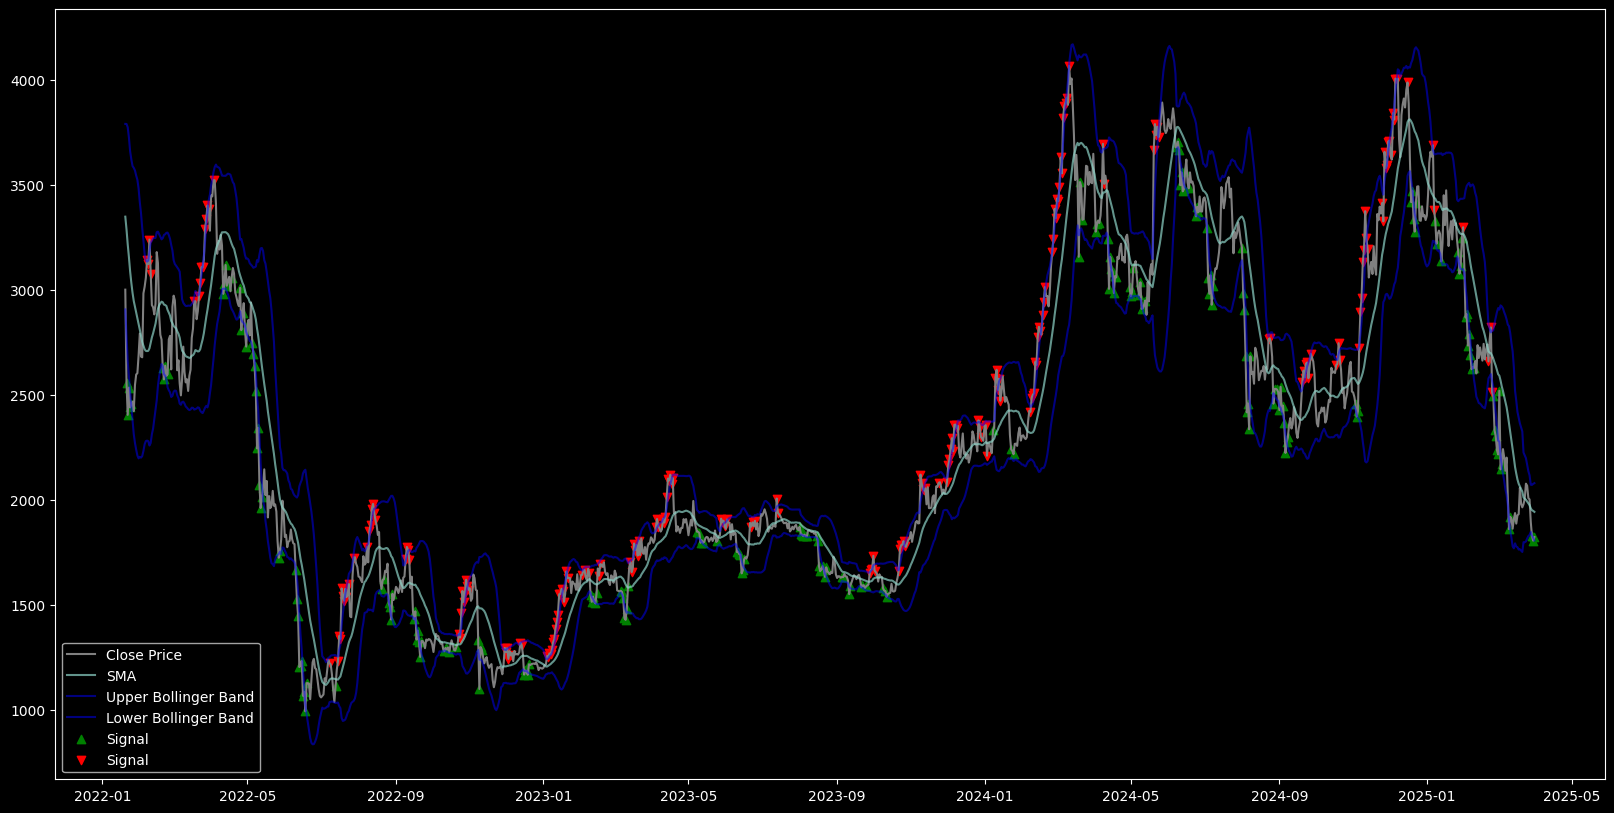

In [10]:
# Afficher les bandes de bollinger & signal (IA)
plt.figure(figsize=(20, 10)) # Change la taille ICI 
plt.plot(df['Close'], label='Close Price', color='grey')
plt.plot(df['SMA'], label='SMA', alpha=0.7)
plt.plot(df['Upper_BB'], label='Upper Bollinger Band', alpha=0.5, color='blue')
plt.plot(df['Lower_BB'], label='Lower Bollinger Band', alpha=0.5, color='blue')
plt.scatter(df[df['signal']==1].index, df[df['signal']==1]['Close'], label='Signal', marker='^', color='green')
plt.scatter(df[df['signal']==-1].index, df[df['signal']==-1]['Close'], label='Signal', marker='v', color='red')
plt.legend()

>Observation :  
> - Les stratégies de retour à la moyenne sont très sensibles aux mouvements de prix importants.  
> - Il est donc essentiel d'éviter les périodes de forte volatilité baissière notre stratégie LongOnly.

---
2.2) Le Filtre de volatilité

In [11]:
def calculate_negative_volatility(df, price_col='Close', window=20):
    # On calcule les variations entre chaque jours
    returns = df[price_col].pct_change()
    # On ne garde que les retours négatifs
    negative_returns = returns.where(returns < 0, 0)
    # On calcule la volatilité des retours négatifs
    downside_vol = negative_returns.rolling(window=window).std()
    return downside_vol

In [12]:
# Calcul de la volatilité_negative
df['neg_vol'] = calculate_negative_volatility(df, price_col='Close', window=10)

# Crée une colonne avec le filtre de volatilité
threshold = 0.025
df.loc[df['neg_vol'] > threshold, 'volat_filter'] = 0
df.loc[df['neg_vol'] <= threshold, 'volat_filter'] = 1

In [13]:
# Applique le filtre de volatilité
df.loc[df['volat_filter'] == 0, 'signal'] = 0

---
2.3) Affichage des signaux et filtres avec matplotlib (IA)


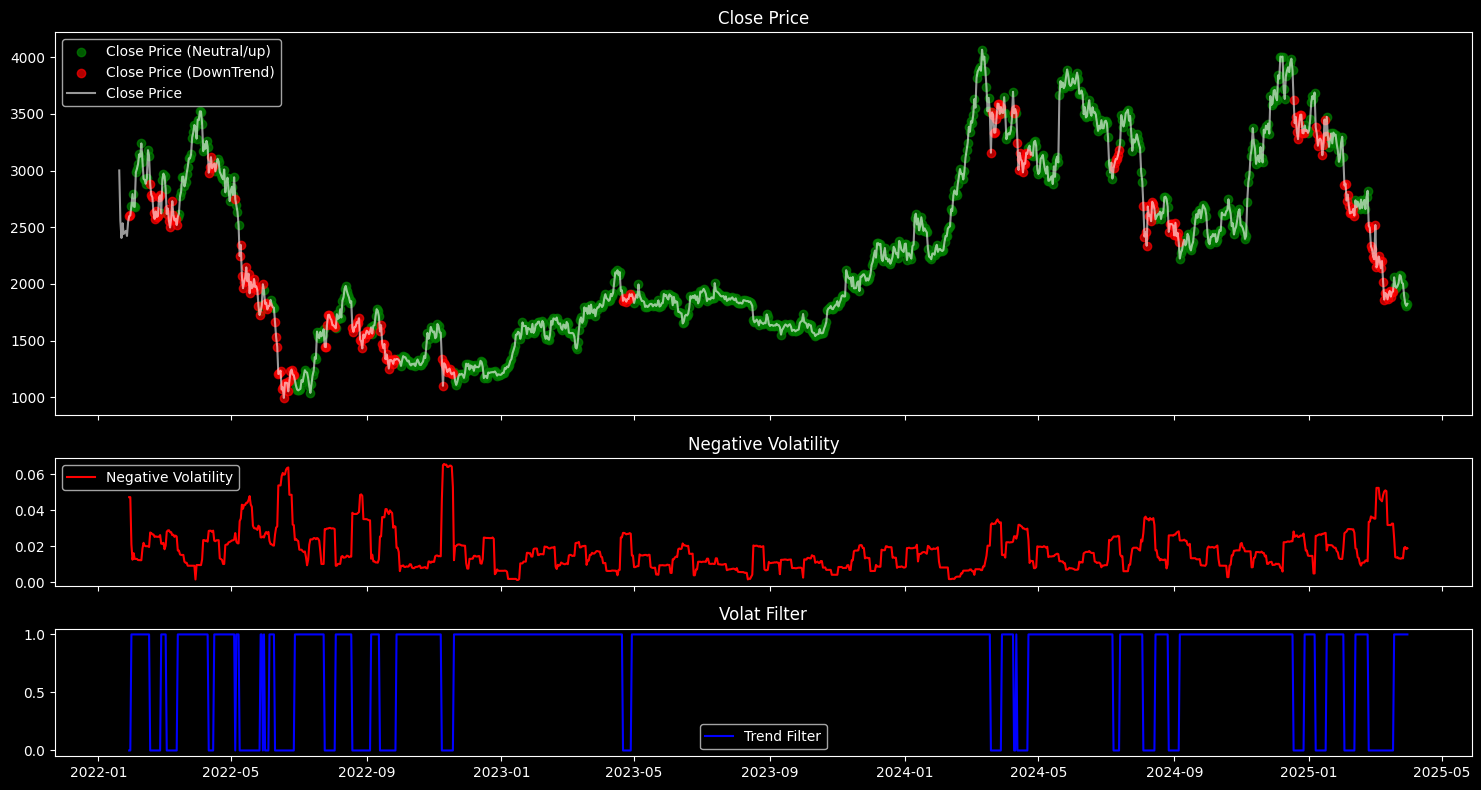

In [14]:
# Create a figure with three subplots sharing x-axis with adjusted height ratios
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,8), sharex=True, height_ratios=[3,1,1])

# Plot Close price on first subplot with colors based on trend filter
ax1.scatter(df[df['volat_filter'] == 1].index, 
           df[df['volat_filter'] == 1]['Close'],
           color='green', label='Close Price (Neutral/up)', alpha=0.7)
ax1.scatter(df[df['volat_filter'] == 0].index,
           df[df['volat_filter'] == 0]['Close'], 
           color='red', label='Close Price (DownTrend)', alpha=0.7)

ax1.plot(df.index, df['Close'], color='white', label='Close Price', alpha=0.6)
ax1.set_title('Close Price')
ax1.legend()

# Plot negative volatility on third subplot
ax2.plot(df.index, df['neg_vol'], label='Negative Volatility', color='red')
ax2.set_title('Negative Volatility')
ax2.legend()

# Plot trend filter on second subplot
ax3.plot(df.index, df['volat_filter'], label='Trend Filter', color='blue')
ax3.set_title('Volat Filter')
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

---
### 3) Le backtest
---

> - Pas de gestion des tailles de position (0 ou 100%)   
> - Une position à la fois
> - On limite le temps d'un trade à 15 bars/jours (fortement conseillé pour les stratégies MR)

---
3.1) Génération des positions

In [15]:
# Crée une colonne position initialisée avec des NaN
df['position'] = np.nan
# Place 1 pour les signaux d'entrée
df.loc[df['signal'] == 1, 'position'] = 1
# Place 0 pour les signaux de sortie
df.loc[df['signal'] == -1, 'position'] = 0

In [16]:
df['2022-04-30':'2022-05-05']

Price,Close,High,Low,Open,Volume,SMA,Upper_BB,Lower_BB,signal,neg_vol,volat_filter,position
Date,,,,,,,,,,,,
2022-04-30,2730.186768,2836.827637,2727.406250,2815.533447,13520941867,2974.414282,3148.629183,2800.199381,1,0.022417,1.0,1.0
2022-05-01,2827.756104,2838.704346,2728.078857,2729.994141,15332730152,2966.749475,3149.607296,2783.891654,1,0.022825,1.0,1.0
2022-05-02,2857.410400,2874.145996,2785.522949,2827.614014,18609741545,2958.101172,3143.606146,2772.596197,0,0.023259,1.0,NaN
2022-05-03,2783.476318,2859.193359,2762.118652,2857.152344,13026093219,2941.357776,3126.538246,2756.177305,0,0.023365,1.0,NaN
2022-05-04,2940.644775,2956.686768,2779.273682,2783.131104,18186749944,2937.394543,3119.892643,2754.896443,0,0.023713,1.0,NaN
2022-05-05,2749.213135,2948.960693,2704.916260,2940.226562,22642925048,2922.809375,3113.635803,2731.982947,0,0.027356,0.0,NaN


In [17]:
# Étape 1: Propager la dernière valeur valide vers l'avant pour remplir les positions
df['position'] = df['position'].ffill()

In [18]:
df['2022-04-30':'2022-05-05']

Price,Close,High,Low,Open,Volume,SMA,Upper_BB,Lower_BB,signal,neg_vol,volat_filter,position
Date,,,,,,,,,,,,
2022-04-30,2730.186768,2836.827637,2727.406250,2815.533447,13520941867,2974.414282,3148.629183,2800.199381,1,0.022417,1.0,1.0
2022-05-01,2827.756104,2838.704346,2728.078857,2729.994141,15332730152,2966.749475,3149.607296,2783.891654,1,0.022825,1.0,1.0
2022-05-02,2857.410400,2874.145996,2785.522949,2827.614014,18609741545,2958.101172,3143.606146,2772.596197,0,0.023259,1.0,1.0
2022-05-03,2783.476318,2859.193359,2762.118652,2857.152344,13026093219,2941.357776,3126.538246,2756.177305,0,0.023365,1.0,1.0
2022-05-04,2940.644775,2956.686768,2779.273682,2783.131104,18186749944,2937.394543,3119.892643,2754.896443,0,0.023713,1.0,1.0
2022-05-05,2749.213135,2948.960693,2704.916260,2940.226562,22642925048,2922.809375,3113.635803,2731.982947,0,0.027356,0.0,1.0


In [19]:
# Étape 2: Remplir les valeurs NaN restantes avec 0 (avant le premier signal)
df['position'] = df['position'].fillna(0)
# Étape 3: Convertir en type entier
df['position'] = df['position'].astype(int)

<Axes: xlabel='Date'>

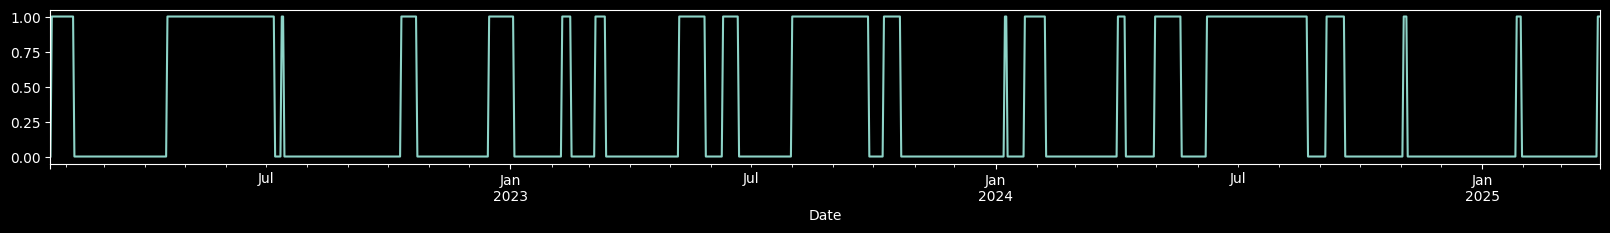

In [20]:
df.position.plot(figsize=(20,2))

---
3.2) Ajout d'un compteur de durée de détention

In [21]:
def apply_hold_limit_basic(df, max_bars=15):
    # Initialise le compteur à 0
    df['hold_counter'] = 0

    # Itération sur les lignes du DataFrame
    for i in range(1, len(df)):

        # Si la position est 1 (achat)
        if df['position'].iloc[i] == 1:

            # Si la position précédente est déjà 1 on incrémente le compteur
            if df['position'].iloc[i - 1] == 1:
                df.loc[df.index[i], 'hold_counter'] = df['hold_counter'].iloc[i - 1] + 1

            # Si c'est une nouvelle position on initialise le compteur à 1
            else:
                df.loc[df.index[i], 'hold_counter'] = 1

    # Ferme la position si la durée dépasse la limite
    df.loc[df['hold_counter'] >= max_bars, 'position'] = 0
    
    return df


In [22]:
df = apply_hold_limit_basic(df, max_bars=15)

In [23]:
df['2022-04-15':'2022-05-04']

Price,Close,High,Low,Open,Volume,SMA,Upper_BB,Lower_BB,signal,neg_vol,volat_filter,position,hold_counter
Date,,,,,,,,,,,,,
2022-04-15,3040.916504,3044.287354,3001.123291,3020.134521,11256651536,3265.445105,3553.313961,2977.576249,0,0.028742,0.0,0,0
2022-04-16,3062.310303,3074.886963,3016.421143,3041.123291,8766710365,3253.981738,3551.708590,2956.254887,0,0.023163,1.0,0,0
2022-04-17,2993.403320,3075.775879,2989.043945,3061.881836,10463091281,3236.820178,3548.323520,2925.316837,0,0.022835,1.0,0,0
2022-04-18,3057.606689,3062.520996,2893.912842,2993.483887,18629381299,3219.601123,3530.837550,2908.364696,1,0.023349,1.0,1,1
2022-04-19,3104.106445,3125.084229,3035.535156,3057.570312,14156035096,3205.548547,3512.350187,2898.746907,0,0.023349,1.0,1,2
2022-04-20,3077.745850,3157.885742,3045.288330,3103.935059,15547362265,3195.353699,3504.246464,2886.460934,0,0.023410,1.0,1,3
2022-04-21,2987.480713,3173.451416,2962.410400,3077.829346,20783591093,3172.250122,3473.140495,2871.359749,0,0.013294,1.0,1,4
2022-04-22,2964.835693,3024.854492,2942.358643,2986.938721,16782795477,3148.238940,3438.074065,2858.403816,0,0.012923,1.0,1,5
2022-04-23,2938.114014,2975.322754,2926.740234,2964.802246,9116955609,3119.002966,3377.414332,2860.591601,0,0.012458,1.0,1,6


<Axes: xlabel='Date'>

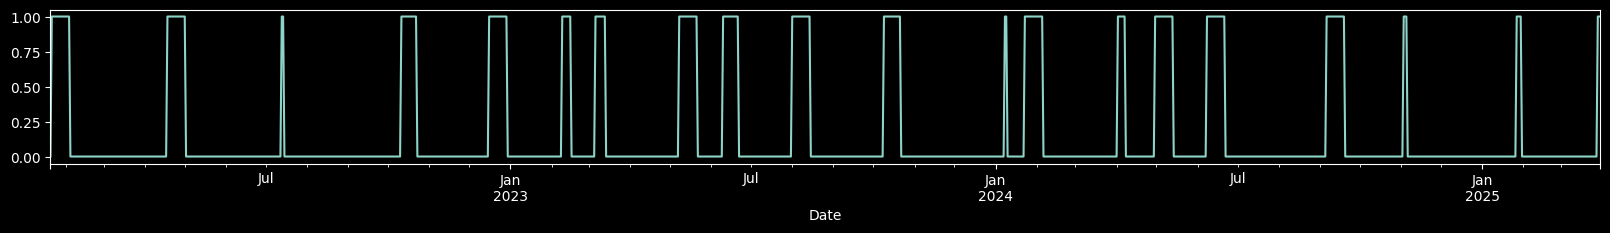

In [24]:
df.position.plot(figsize=(20,2))

---
3.3) Calcul des performances


In [25]:
# 1. Calcul des rendements
df['market_ret'] = df['Close'].pct_change()

In [26]:
# 2. Calcul des rendements de la stratégie : prend les rendements uniquement quand en position (signal == 1)
df['strategy_ret'] = df['position'].shift(1) * df['market_ret']

### 🧪 Exemple de `shift(1)` dans une stratégie de trading

| Date | Close | position | market_ret | position.shift(1) | strategy_ret |
|------|-------|----------|------------|--------------------|---------------|
| t-2  | 100   | 0        | NaN        | NaN                | NaN           |
| t-1  | 105   | 1        | 0.0500     | 0                  | 0.0000        |
| t    | 110   | 1        | 0.0476     | 1                  | 0.0476        |


- À `t-1`, la stratégie décide d’entrer en position à la cloture (`position = 1`).
- À `t`, on est effectivement en position, donc on capte le rendement de cette journée et pas de celle qui précède.

In [27]:
# 3. Rendements cumulés
df['strategy_cumret'] = (1 + df['strategy_ret']).cumprod()

# Rendement cumulé total (performance finale - 1)
total_return = df['strategy_cumret'].iloc[-1] - 1

print(f"✅ Rendement total: {total_return:.2%}")

✅ Rendement total: 160.67%


In [28]:
# Calcul du drawdown maximal
cum_returns = df['strategy_cumret']
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1
max_drawdown = drawdown.min()

# Calcul du ratio de Sharpe
sharpe_ratio = np.sqrt(365) * df['strategy_ret'].mean() / df['strategy_ret'].std()

# Affichage du résumé des performances
print(f"✅ Rendement total: {total_return:.2%}")
print(f"📉 Drawdown maximal: {max_drawdown:.2%}")
print(f"📊 Ratio de Sharpe: {sharpe_ratio:.2f} *annualisé")

✅ Rendement total: 160.67%
📉 Drawdown maximal: -13.44%
📊 Ratio de Sharpe: 1.50 *annualisé


--- 
3.4) Affichage des performances

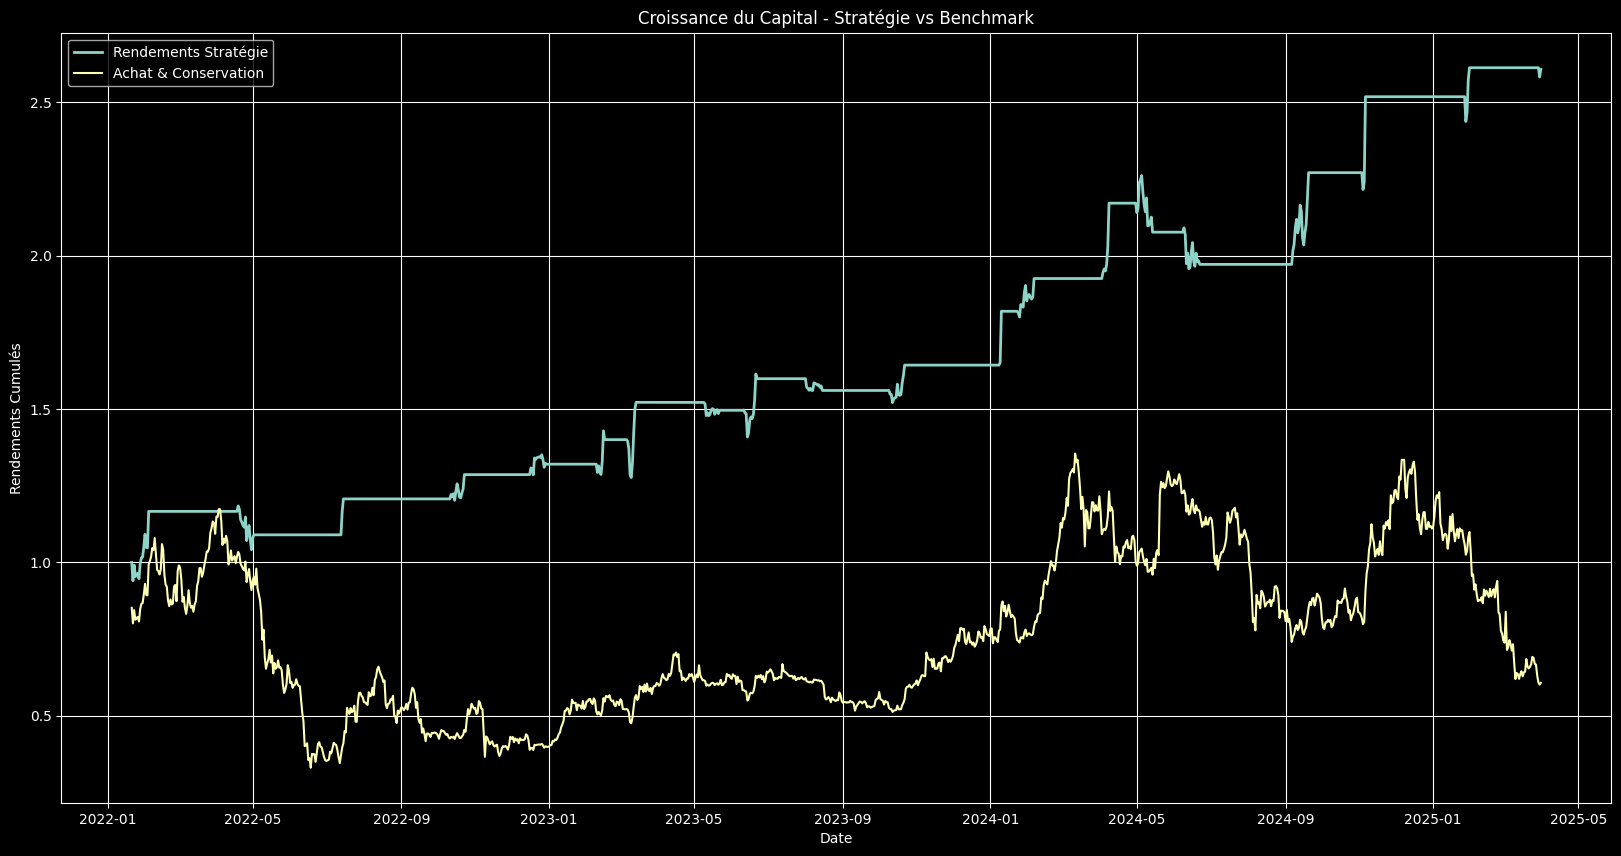

In [29]:
# Tracer les rendements cumulés (croissance du capital) de la stratégie et du benchmark
plt.figure(figsize=(20,10))
plt.plot(df.index, df['strategy_cumret'], label='Rendements Stratégie', linewidth=2)
plt.plot(df.index, (1 + df['market_ret']).cumprod(), label='Achat & Conservation')
plt.title('Croissance du Capital - Stratégie vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Rendements Cumulés')
plt.grid(True)
plt.legend()